# CNN For Predicting Welding Quality

In [1]:
import matplotlib.pyplot as plt
import tensorflow as tf
import util
import numpy as np
from config import *
from cnn import Cnn
%matplotlib inline

## Prepare data

Data is a three-dimensional time series consisting of **electrode position, current, and voltage**

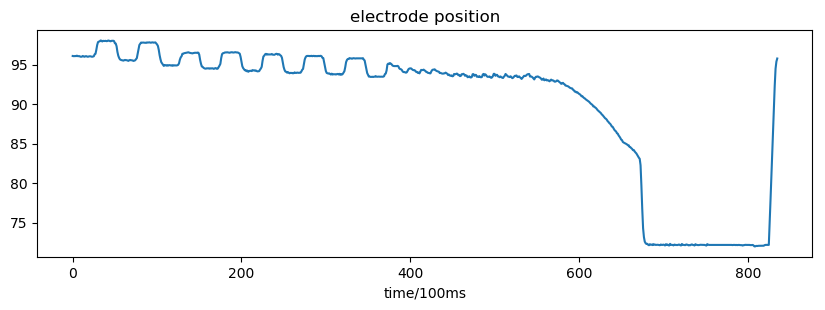

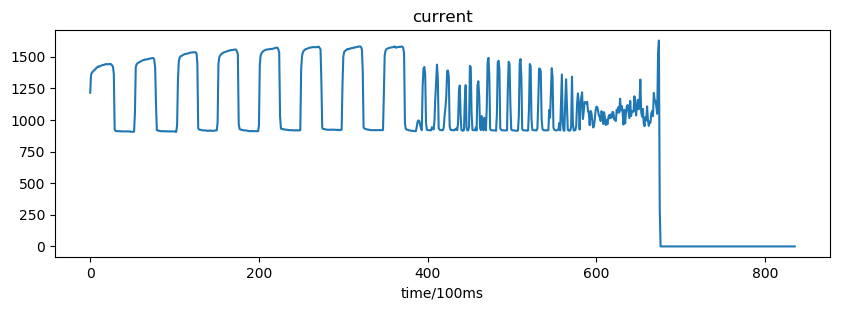

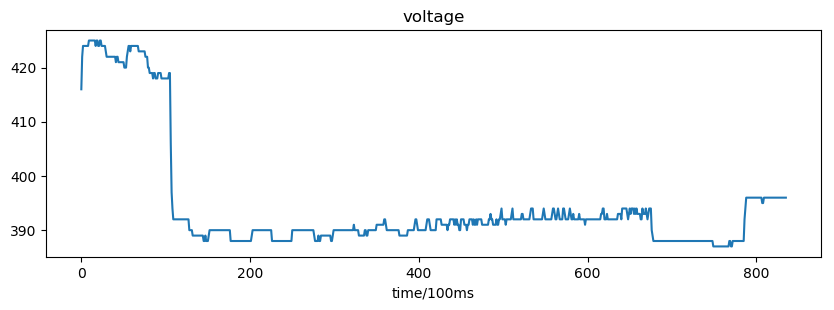

In [2]:
data, num1, num2 = util.load_data(False)
plt.figure(figsize=(10, 3), dpi= 100)
plt.xlabel('time/100ms')
plt.title('electrode position')
plt.plot(data[0][:, 0])

plt.figure(figsize=(10, 3), dpi= 100)
plt.xlabel('time/100ms')
plt.title('current')
plt.plot(data[0][:, 1])

plt.figure(figsize=(10, 3), dpi= 100)
plt.xlabel('time/100ms')
plt.title('voltage')
plt.plot(data[0][:, 2])

plt.show()

We use downsampling to make the sequences equal in length. It can be seen that after downsampling to a length of 600, there is not much loss in the characteristics of the data.

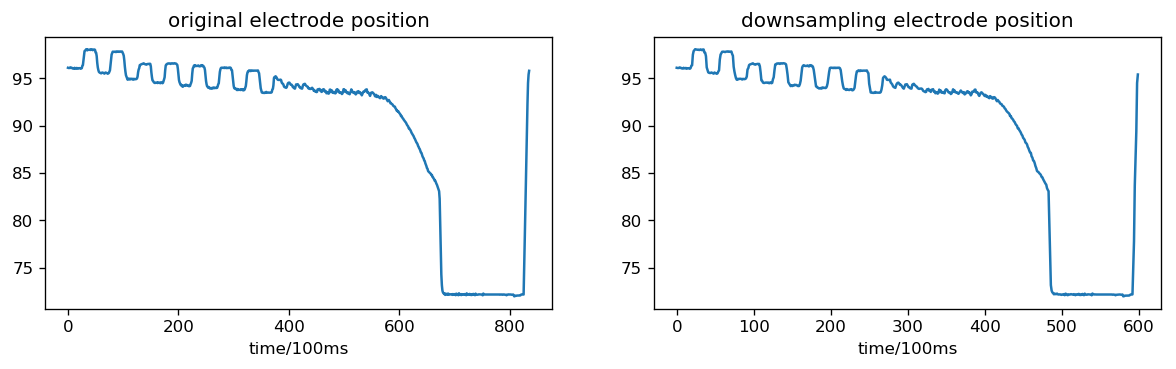

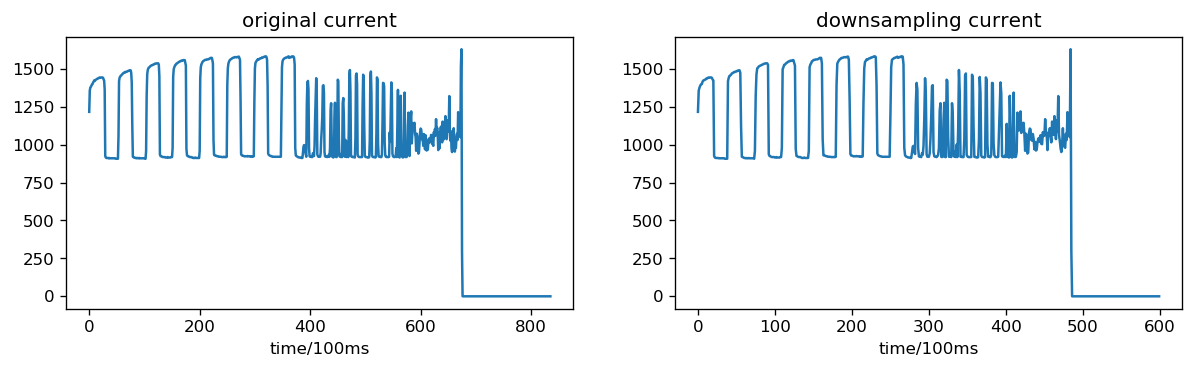

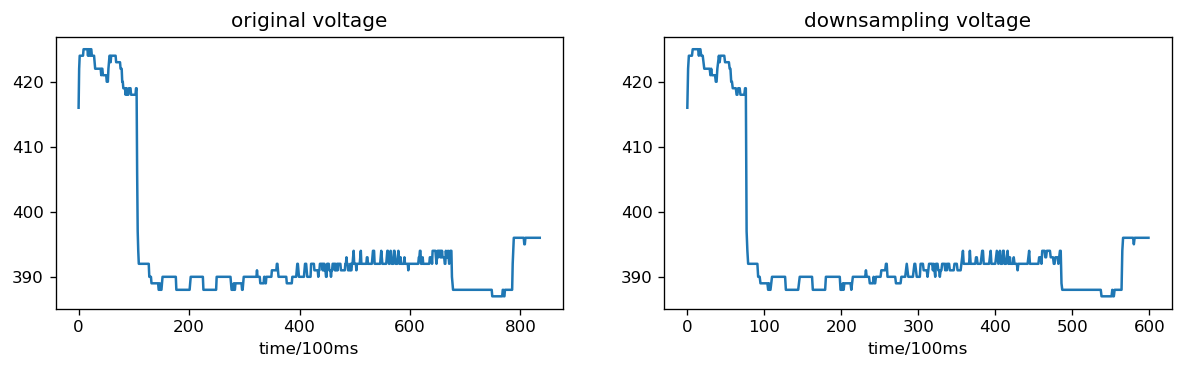

In [3]:
data2, length = util.resample(data, 600)
plt.figure(figsize=(12, 3), dpi= 120)
plt.subplot(121)
plt.title('original electrode position')
plt.xlabel('time/100ms')
plt.plot(data[0][:, 0])
plt.subplot(122)
plt.title('downsampling electrode position')
plt.xlabel('time/100ms')
plt.plot(data2[0][:, 0])

plt.figure(figsize=(12, 3), dpi= 120)
plt.subplot(121)
plt.title('original current')
plt.xlabel('time/100ms')
plt.plot(data[0][:, 1])
plt.subplot(122)
plt.title('downsampling current')
plt.xlabel('time/100ms')
plt.plot(data2[0][:, 1])

plt.figure(figsize=(12, 3), dpi= 120)
plt.subplot(121)
plt.title('original voltage')
plt.xlabel('time/100ms')
plt.plot(data[0][:, 2])
plt.subplot(122)
plt.title('downsampling voltage')
plt.xlabel('time/100ms')
plt.plot(data2[0][:, 2])

plt.show()

## Data Augmentation

Since we only have 50 bad samples, we use ADASYN to expand the number of minority class e.g. bad class.

Morever we also use F1 score to evaluation model.

For more information, you can read my blog about [ADASYN](https://masterwangzx.com/2019/04/08/SMOTE/#adasyn)

In [4]:
# the number of data for train and test, must smaller than 2050
num_data = 2000

In [5]:
data, num_good, num_bad = util.load_data(num_data // 2)

# resample
data, length = util.resample(data, 600)
data = util.reshape(data, length)
good_data_origin = data[:num_good, :]
bad_data_origin = data[num_good:, :]

# extract bad data for test and train
permutation = list(np.random.permutation(len(bad_data_origin)))
shuffled_bad_data = bad_data_origin[permutation, :]
test_bad_data = shuffled_bad_data[:int(num_bad * 0.3), :]
train_bad_data_origin = shuffled_bad_data[int(num_bad * 0.3):, :]
# extract corresponding good data for test and train
permutation = list(np.random.permutation(len(good_data_origin)))
shuffled_good_data = good_data_origin[permutation, :]
test_good_data = shuffled_good_data[:len(test_bad_data), :]
train_good_data = shuffled_good_data[len(test_bad_data):, :]

# construct test data
test_y = np.array([1.] * len(test_good_data) + [0.] * len(test_bad_data), dtype=np.float).reshape((len(test_bad_data) + len(test_good_data), 1))
test_x = np.vstack((test_good_data, test_bad_data))

# expand the number of bad data for train
train_x = np.vstack((train_good_data, train_bad_data_origin))
train_y = np.array([1.] * len(train_good_data) + [0.] * len(train_bad_data_origin), dtype=np.float).reshape((len(train_bad_data_origin) + len(train_good_data), 1))
train_x, train_y, num_expand = util.expand(train_x, train_y)

# regularize
for i in range(len(train_x)):
    train_x[i, :, 0] = util.regularize(train_x[i, :, 0])
    train_x[i, :, 1] = util.regularize(train_x[i, :, 1])
    train_x[i, :, 2] = util.regularize(train_x[i, :, 2])
for i in range(len(test_x)):
    test_x[i, :, 0] = util.regularize(test_x[i, :, 0])
    test_x[i, :, 1] = util.regularize(test_x[i, :, 1])
    test_x[i, :, 2] = util.regularize(test_x[i, :, 2])

# random
train_x, train_y = util.shuffle_data(train_x, train_y)

# Hyperparameters

In [6]:
# numbers of neurons in each convolution layer, 0 is the max pool, -1 is the dropout
conv_layers = [18, 0, 36, 0, 72, -1, 0, 144]

# (filter size, step, pad) in filters in each layers. For pad, fill in 'SAME' or 'VALID'.
# Must correspond to conv_layers. If it is dropout, fill with 0
filters = [(2, 1, 'SAME'), (2, 2, 'SAME'), (2, 1, 'SAME'), (2, 2, 'SAME'), (2, 1, 'SAME'), 0, (2, 2, 'SAME'),
           (2, 1, 'SAME')]

# the dims of full connected layers. The last layer is 1 and you do not need to write it on. Already implement dropout.
fc_layers = []

learning_rate = 0.00005

num_epochs = 150

# 0->disable
mini_batch_size = 64

# dropout
keep_prob = 0.3

## Construct CNN

In [7]:
graph = tf.Graph()

with graph.as_default():
    cnn = Cnn(conv_layers, fc_layers, filters, learning_rate)
    (m, n_W0, n_C0) = train_x.shape
    n_y = train_y.shape[1]
    
    cnn.initialize(n_W0, n_C0, n_y)
    cnn.forward()
    cost = cnn.cost()
    optimizer = cnn.get_optimizer(cost)
    predict, accuracy, f1 = cnn.predict()

## Train

In [8]:
# log the cost and accuracy
cost_log = []
test_log = []
train_log = []
x = []

with tf.Session(graph=graph) as sess:
    sess.run(tf.global_variables_initializer())

    for i in range(1, num_epochs + 1):
        if mini_batch_size != 0:
            num_mini_batches = int(m / mini_batch_size)
            mini_batches = util.random_mini_batches(train_x, train_y, mini_batch_size)

            cost_value = 0
            for mini_batch in mini_batches:
                (mini_batch_x, mini_batch_y) = mini_batch
                _, temp_cost = sess.run([optimizer, cost], feed_dict={cnn.x: mini_batch_x, cnn.y: mini_batch_y, cnn.keep_prob: keep_prob})
                cost_value += temp_cost
            cost_value /= num_mini_batches
        else:
            _, cost_value = sess.run([optimizer, cost], feed_dict={cnn.x: train_x, cnn.y: train_y, cnn.keep_prob: keep_prob})

        # disable dropout
        train_accuracy, output = sess.run([accuracy, predict], feed_dict={cnn.x: train_x, cnn.y: train_y, cnn.keep_prob: 1})
        test_accuracy = sess.run(accuracy, feed_dict={cnn.x: test_x, cnn.y: test_y, cnn.keep_prob: 1})
        f1_test = sess.run(f1, feed_dict={cnn.x: test_x, cnn.y: test_y, cnn.keep_prob: 1})

        cost_log.append(cost_value)
        train_log.append(train_accuracy)
        test_log.append(test_accuracy)
        x.append(i)

        if print_detail and (i % 10 == 0 or i == 1):
            print('Iteration '+str(i))
            print('Cost: '+str(cost_value))
            print('Train accuracy: '+str(train_accuracy))
            print('Test accuracy: '+str(test_accuracy))
            print('F1 score: '+str(f1_test))
            print()

Iteration 1
Cost: 0.6301238854726156
Train accuracy: 0.5106707
Test accuracy: 0.6
F1 score: 0.33333333333333337

Iteration 10
Cost: 0.1264749174316724
Train accuracy: 0.9517276
Test accuracy: 0.93333334
F1 score: 0.9285714285714286

Iteration 20
Cost: 0.06619310639798641
Train accuracy: 0.9791667
Test accuracy: 0.96666664
F1 score: 0.9655172413793104

Iteration 30
Cost: 0.045415331485370795
Train accuracy: 0.9893293
Test accuracy: 0.96666664
F1 score: 0.9655172413793104

Iteration 40
Cost: 0.03178299639063577
Train accuracy: 0.9893293
Test accuracy: 1.0
F1 score: 1.0

Iteration 50
Cost: 0.025386922488299508
Train accuracy: 0.9933943
Test accuracy: 0.96666664
F1 score: 0.967741935483871

Iteration 60
Cost: 0.01946865948072324
Train accuracy: 0.9964431
Test accuracy: 0.96666664
F1 score: 0.967741935483871

Iteration 70
Cost: 0.018962323983820775
Train accuracy: 0.99745935
Test accuracy: 0.96666664
F1 score: 0.967741935483871

Iteration 80
Cost: 0.015260076701330642
Train accuracy: 0.9979

## Chart

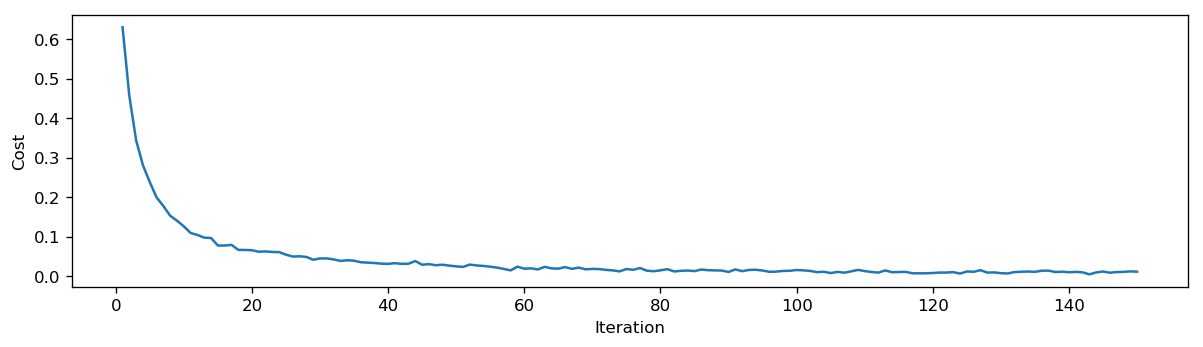

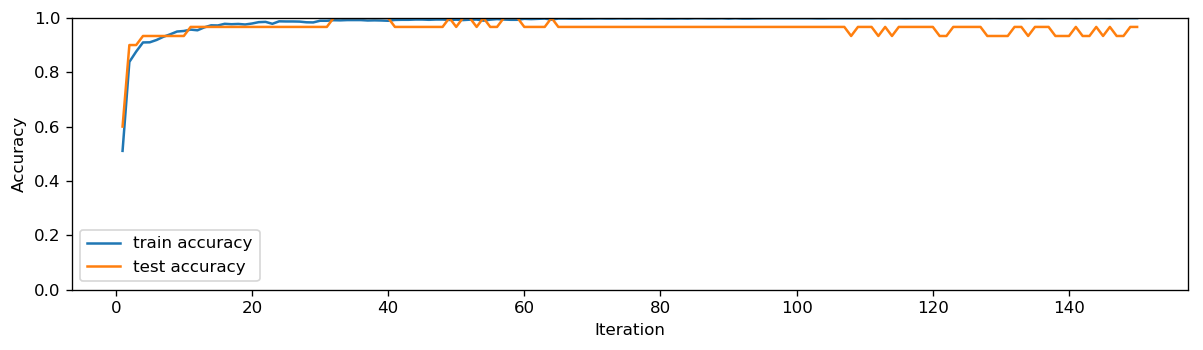

In [9]:
plt.figure(figsize=(12, 3), dpi= 120)
plt.xlabel('Iteration')
plt.ylabel('Cost')
plt.plot(x, cost_log)

plt.figure(figsize=(12, 3), dpi= 120)
plt.xlabel('Iteration')
plt.ylabel('Accuracy')
plt.ylim(0, 1)
plt.plot(x, train_log, label='train accuracy')
plt.plot(x, test_log, label='test accuracy')
plt.legend()

plt.show()